# Red Convolucional en PyTorch

Las redes neuronales convolucionales utilizan principalmente tres tipos de capas

## Capas de una red convolucional

Las capas que le dan su nombre a esta arquitectura son las [capas convolucionales](https://pytorch.org/docs/stable/nn.html#convolution-layers). En estas capas:

- Las neuronas de estas capas se organizan en filtros 
- Se realiza la correlación cruzada entre la imagen de entrada y los filtros
- Existen capas convolucionales 1D, 2D y 3D

:::{seealso}

[Visualización de convoluciones con distintos tamaños, strides, paddings, dilations](https://github.com/vdumoulin/conv_arithmetic)

:::

Los argumentos de la capa convolución de dos dimensiones son:

```python
torch.nn.Conv2d(in_channels, #Cantidad de canales de la imagen de entrada
                out_channels, #Cantidad de bancos de filtro
                kernel_size, #Tamaño de los filtros (entero o tupla)
                stride=1, #Paso de los filtros
                padding=0, #Cantidad de filas y columnas para agregar a la entrada antes de filtrar
                dilation=1, #Espacio entre los pixeles de los filtros
                groups=1, #Configuración cruzada entre filtros de entrada y salida
                bias=True,  #Utilizar sesgo (b)
                padding_mode='zeros' #Especifica como agregar nuevas filas/columnas (ver padding)
                )
```

Las [capas de pooling](https://pytorch.org/docs/stable/nn.html#pooling-layers) son capas que reducen la dimensión (tamaño) de su entrada

Se usa tipicamente luego de una capa de convolución "activada" y realiza una operación no entrenable: 

Por ejemplo:

- Promedio de los píxeles en una región (kernel_size=2, stride=2)

        1 2 1 0
        2 3 1 2      2.00 1.00
        0 1 0 1      0.75 0.25
        2 0 0 0

- Máximo de los pixeles en una región (kernel_size=2, stride=2)

        1 2 1 0
        2 3 1 2      3 2
        0 1 0 1      2 1
        2 0 0 0

Estas capas ayudan a reducir la complejidad del modelo y también otorgan "invarianza local a la traslación", es decir que la posición donde estaba el patrón es menos relevante luego de aplicar pooling

Los argumentos de MaxPooling para entradas de dos dimensiones son:

```python
torch.nn.MaxPool2d(kernel_size, # Mismo significado que en Conv2d
                   stride=None, # Mismo significado que en Conv2d
                   padding=0, #Mismo significado que en Conv2d
                   dilation=1, #Mismo significado que en Conv2d
                   return_indices=False, #Solo necesario para hacer unpooling
                   ceil_mode=False #Usar ceil en lugar de floor para calcular el tamaño de la salida
                  )
```

:::{note}

Las [capas completamente conectadas](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear) también se utilizan en redes convolucionales

:::


## Librería [`torchvision`](https://pytorch.org/vision/stable/index.html)

Es una librería utilitaria de PyTorch que facilita considerablemente el trabajo con imágenes. Algunas de las funciones y clases que provee:

- Funcionalidad para descargar sets de benchmark: MNIST, CIFAR, IMAGENET, ...
- Modelos clásicos pre-entrenados: AlexNet, VGG, GoogLeNet, ResNet
- Funciones para importar imágenes en distintos formatos
- Funciones de transformación para hacer aumentación de datos en imágenes


**Ejemplo:** Base de datos de imágenes de dígitos manuscritos MNIST

- Imágenes de 28x28 píxeles en escala de grises
- Diez categorías: Dígitos manuscritos del cero al nueve
- 60.000 imágenes de entrenamiento, 10.000 imágenes de prueba
- Por defecto las imágenes vienen en [formato PIL](https://pillow.readthedocs.io/en/stable/) (entero 8bit), usamos la transformación [`ToTensor()`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.ToTensor) para convertirla a tensor en float32


In [1]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

mnist_train_data = MNIST(root='~/datasets/', train=True, download=True, 
                         transform=transforms.ToTensor())

mnist_test_data = MNIST(root='~/datasets/', train=False, download=True, 
                        transform=transforms.ToTensor())

image, label = mnist_train_data[0]
display(len(mnist_train_data), type(image), image.dtype, type(label))

60000

torch.Tensor

torch.float32

int

A continuación se muestran 10 imágenes aleatorias de MNIST junto a sus etiquetas:

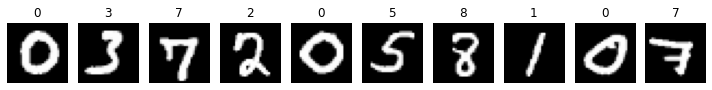

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 10, figsize=(10, 2), tight_layout=True)
idx = np.random.permutation(len(mnist_train_data))[:10]

for k in range(10):
    image, label = mnist_train_data[idx[k]]
    ax[k].imshow(image[0, :, :].numpy(), cmap=plt.cm.Greys_r)
    ax[k].axis('off');
    ax[k].set_title(label)
    

Luego creamos dataloaders de entrenamiento y validación como hemos visto anteriormente:

In [3]:
import torch
import torch.utils.data as tdata

mnist_train, mnist_valid = tdata.random_split(mnist_train_data, [50_000, 10_000], 
                                              generator=torch.Generator().manual_seed(1234))
train_loader = tdata.DataLoader(mnist_train, shuffle=True, batch_size=32)
valid_loader = tdata.DataLoader(mnist_valid, shuffle=False, batch_size=256)

## Mi primera red convolucional para clasificar en pytorch

Clasificaremos la base de datos MNIST 

Para esto implementaremos la clásica arquitectura Lenet5

<img src="img/LeNet5.png" width="800">

La arquitectura considera
- Dos capas convolucionales con 6 y 16 bancos de filtros, respectivamente
- Las capas convolucionales usan filtros de 5x5 píxeles
- Se usa max-pooling de tamaño 2x2 y stride 2
- La primera capa convolucional espera un minibatch de imágenes de 1 canal (blanco y negro)
- Usaremos la función de activación [Rectified Linear Unit (ReLU)](https://pytorch.org/docs/stable/nn.html#relu)
- Se usan tres capas completamente conectadas con 120, 84 y 10 neuronas, respectivamente

> Podemos usar `reshape` o `view` para convertir un tensor de 4 dimensiones a dos dimensiones.  Esto prepara un tensor que sale de una capa convolucional (o pooling) para ingresarlo a las capas completamente conectadas

In [4]:
import torch.nn as nn

class Lenet5(nn.Module):
    
    def __init__(self):
        super(type(self), self).__init__()
        # La entrada son imágenes de 1x32x32
        self.features = nn.Sequential(nn.Conv2d(1, 6, 5, padding=2),
                                      nn.ReLU(),
                                      nn.MaxPool2d(2),
                                      nn.Conv2d(6, 16, 5),
                                      nn.ReLU(),
                                      nn.MaxPool2d(2))
        
        self.classifier = nn.Sequential(nn.Linear(16*5*5, 120),
                                        nn.ReLU(),
                                        nn.Linear(120, 84),
                                        nn.ReLU(),
                                        nn.Linear(84, 10))

    def forward(self, x):
        z = self.features(x)
        # Esto es de tamaño Mx16x5x5
        z = z.view(-1, 16*5*5)
        # Esto es de tamaño Mx400
        return self.classifier(z)
    
    
model = Lenet5()
print(model)

Lenet5(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


## Entrenamiento de la red convolucional

- Si tenemos acceso a una GPU podemos usar el atributo `.cuda()` o `.to()` para enviar el modelo y los datos a la GPU para acelerar los cálculos
- Actualizamos los parámetros en el conjunto de entrenamiento
- Medimos la convergencia en el conjunto de validación
- Guardamos el modelo con mejor error de validación
- Usaremos `ignite` para entrenar: `conda install -c pytorch ignite`

In [5]:
from ignite.engine import Engine, Events
from ignite.metrics import Loss, Accuracy

model = Lenet5()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss(reduction='sum')
max_epochs = 5
device = torch.device('cpu')
#device = torch.device('cuda:0')

model = model.to(device)

# Esto es lo que hace el engine de entrenamiento
def train_one_step(engine, batch):
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    yhat = model.forward(x)
    loss = criterion(yhat, y)
    loss.backward()
    optimizer.step()
    return loss.item() # Este output puede llamar luego como trainer.state.output

# Esto es lo que hace el engine de evaluación
def evaluate_one_step(engine, batch):
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        yhat = model.forward(x)
        #loss = criterion(yhat, y)
        return yhat, y

trainer = Engine(train_one_step)
evaluator = Engine(evaluate_one_step)
metrics = {'Loss': Loss(criterion), 'Acc': Accuracy()}
for name, metric in metrics.items():
    metric.attach(evaluator, name)

A modo de ejemplo, entrenaremos por dos épocas:

In [6]:
from ignite.handlers import ModelCheckpoint

@trainer.on(Events.EPOCH_COMPLETED(every=1)) # Cada 1 epocas
def log_results(engine):
    # Evaluo el conjunto de entrenamiento
    evaluator.run(train_loader) 
    loss, acc = evaluator.state.metrics['Loss'], evaluator.state.metrics['Acc']
    print(f"Train epoca: {engine.state.epoch} \t Loss: {loss:.3f} \t Accuracy: {acc:.3f}")
    # Evaluo el conjunto de validación
    evaluator.run(valid_loader) 
    loss, acc = evaluator.state.metrics['Loss'], evaluator.state.metrics['Acc']
    print(f"Valid epoca: {engine.state.epoch} \t Loss: {loss:.3f} \t Accuracy: {acc:.3f}")

# Guardo el mejor modelo en validación
best_model_handler = ModelCheckpoint(dirname='.', require_empty=False, filename_prefix="best", n_saved=1,
                                     score_function=lambda engine: -engine.state.metrics['Loss'],
                                     score_name="val_loss")

# Lo siguiente se ejecuta cada ves que termine el loop de validación
evaluator.add_event_handler(Events.COMPLETED, 
                            best_model_handler, {'lenet5': model})

trainer.run(train_loader, max_epochs=max_epochs)

Train epoca: 1 	 Loss: 2.286 	 Accuracy: 0.978
Valid epoca: 1 	 Loss: 21.313 	 Accuracy: 0.976
Train epoca: 2 	 Loss: 1.728 	 Accuracy: 0.982
Valid epoca: 2 	 Loss: 17.580 	 Accuracy: 0.981
Train epoca: 3 	 Loss: 1.035 	 Accuracy: 0.990
Valid epoca: 3 	 Loss: 14.006 	 Accuracy: 0.984
Train epoca: 4 	 Loss: 1.199 	 Accuracy: 0.989
Valid epoca: 4 	 Loss: 16.315 	 Accuracy: 0.982
Train epoca: 5 	 Loss: 0.841 	 Accuracy: 0.991
Valid epoca: 5 	 Loss: 13.923 	 Accuracy: 0.984


State:
	iteration: 7815
	epoch: 5
	epoch_length: 1563
	max_epochs: 5
	output: 0.005092719104140997
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

## Analizando las predicciones del modelo convolucional

Primero recuperamos la red con menor costo de validación

In [7]:
model = Lenet5()
model.load_state_dict(torch.load('best_lenet5_val_loss=-2.7455.pt'))

<All keys matched successfully>

Haremos la evaluación final del a red en el conjunto de prueba/test

Iteramos sobre el conjunto y guardamos las predicciones de la red

In [8]:
from torch.utils.data import DataLoader

test_loader = DataLoader(mnist_test_data, shuffle=False, batch_size=512)

test_targets = mnist_test_data.targets.numpy()
prediction_test = []
for mbdata, label in test_loader:
    logits = model(mbdata).detach()
    prediction_test.append(logits.argmax(dim=1).numpy())
prediction_test = np.concatenate(prediction_test)

Con esto podemos construir una matriz de confusión y un reporte usando las herramientas de `sklearn`

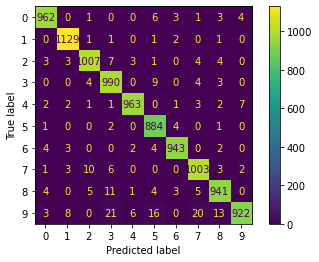

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

ConfusionMatrixDisplay.from_predictions(test_targets, prediction_test);

In [10]:
print(classification_report(test_targets, prediction_test, digits=3))

              precision    recall  f1-score   support

           0      0.982     0.982     0.982       980
           1      0.983     0.995     0.989      1135
           2      0.979     0.976     0.977      1032
           3      0.953     0.980     0.966      1010
           4      0.988     0.981     0.984       982
           5      0.956     0.991     0.973       892
           6      0.986     0.984     0.985       958
           7      0.964     0.976     0.970      1028
           8      0.967     0.966     0.967       974
           9      0.986     0.914     0.949      1009

    accuracy                          0.974     10000
   macro avg      0.974     0.974     0.974     10000
weighted avg      0.975     0.974     0.974     10000



Luego de evaluar la red el siguiente paso es **estudiar sus errores**. Para problemas con imágenes es muy recomendable visualizar los ejemplos mal predichos por la red

Esto podría revelar

- Imágenes mal etiquetadas: Podemos cambiar su etiqueta y re-entrenar/re-evaluar
- Errores sistemáticos del modelo: Por ejemplo que siempre se equivoque con una clase u objeto en particular

Observemos algunos ejemplos mal clasificados

- Las imágenes corresponden a `digit` que no fueron predichos como `digit`
- El título de la imagen tiene la predicción por la red

Veamos 10 ejemplos erroneos para tres clases particulares:

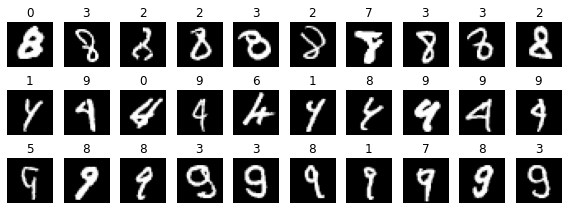

In [11]:
fig, ax = plt.subplots(3, 10, figsize=(8, 3), tight_layout=True)

for k, digit in enumerate([8, 4, 9]):    
    idx = np.where((test_targets == digit) & ~(prediction_test == digit))[0]
    for i in range(10):
        ax[k, i].axis('off')
        if i < len(idx):
            ax[k, i].set_title(prediction_test[idx[i]])
            ax[k, i].imshow(mnist_test_data[idx[i]][0].numpy()[0, :, :], cmap=plt.cm.Greys_r)
    

**Actividad** Según la forma de los dígitos ¿tienen sentido estos errores? Discuta con sus compañeros